[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Loaded 18 docs from /Users/user/Desktop/GAITAR-hashed
→ topic_weights.csv written to /Users/user/Desktop/GAITAR-hashed/topic_weights.csv


/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


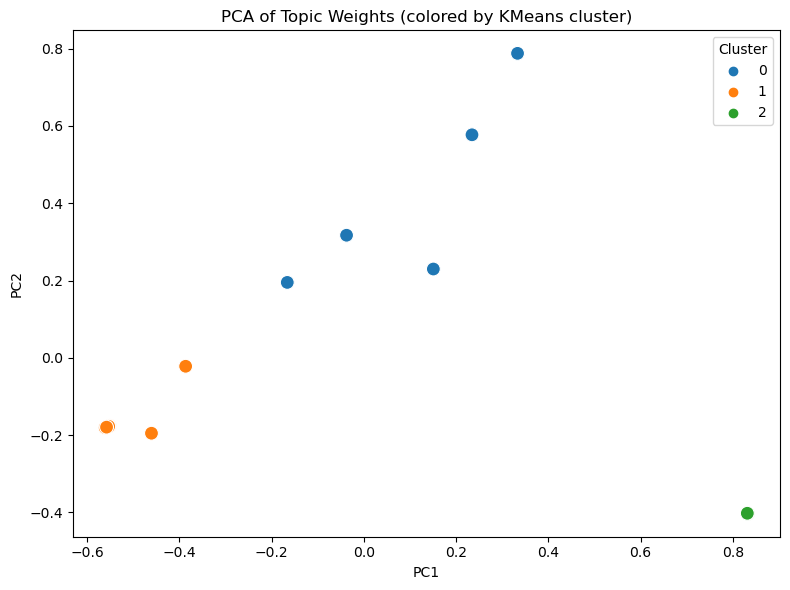

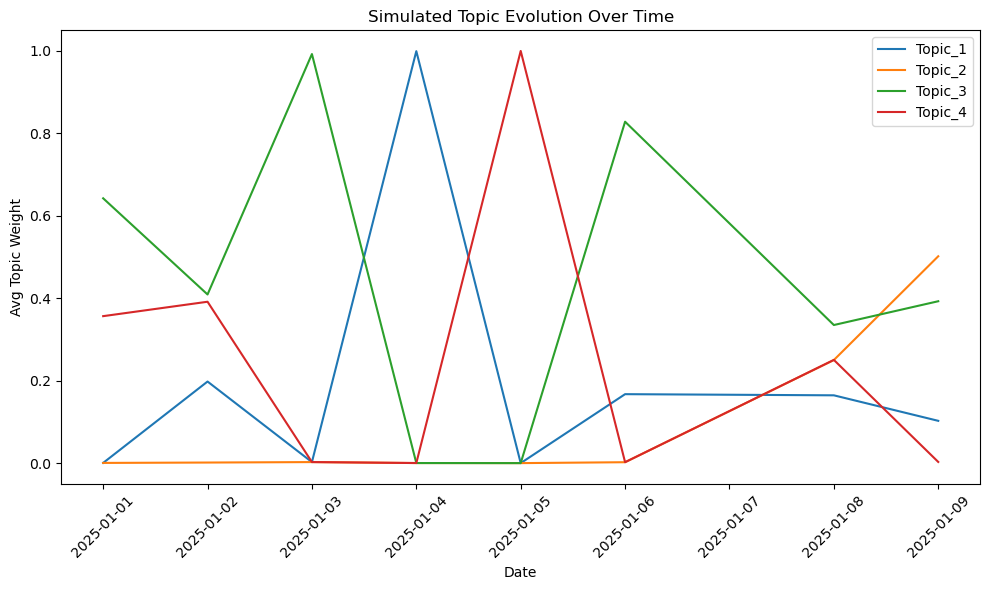

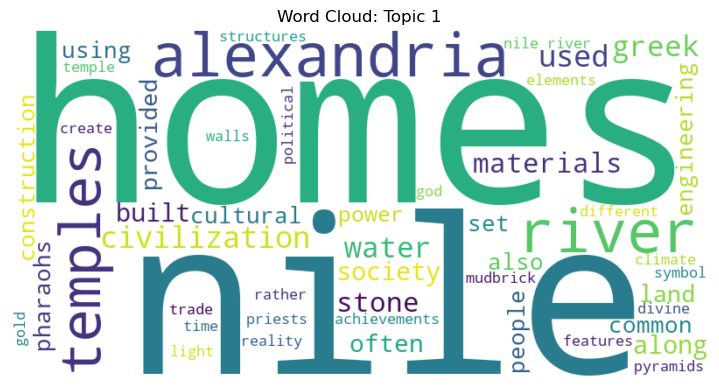

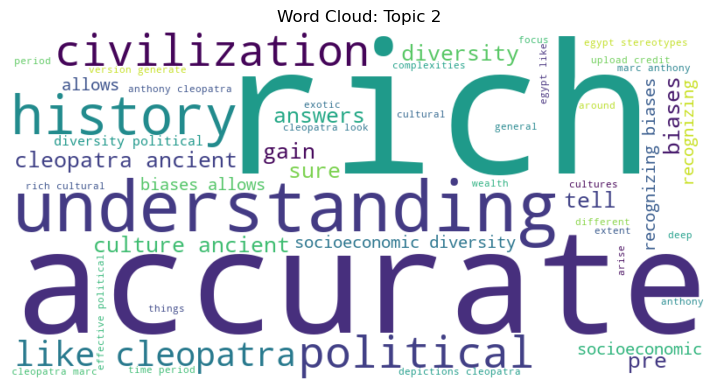

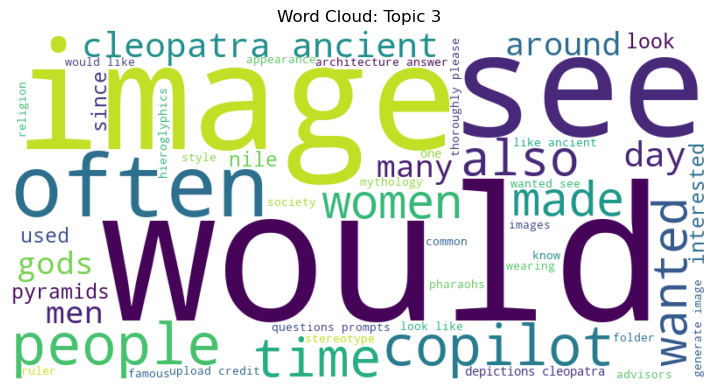

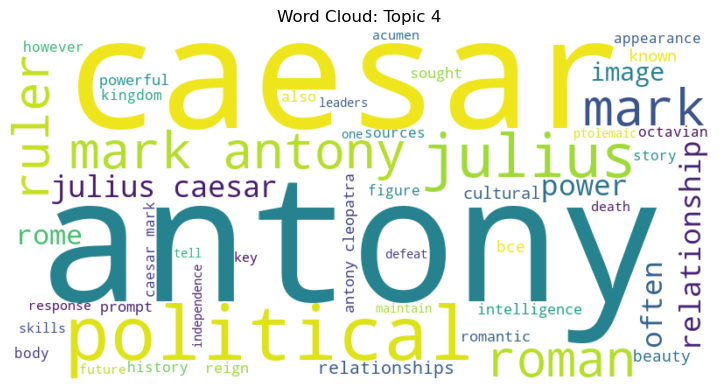

In [1]:

!pip install -q python-docx scikit-learn nltk pandas matplotlib seaborn wordcloud

import os, re
import docx
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from wordcloud import WordCloud

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# ----------------------------------------
# 2) Load & Clean .docx Files
# ----------------------------------------
folder = os.path.expanduser("~/Desktop/GAITAR-hashed")
docs, filenames = [], []
for fn in os.listdir(folder):
    if fn.lower().endswith(".docx"):
        path = os.path.join(folder, fn)
        d = docx.Document(path)
        text = "\n".join(p.text for p in d.paragraphs)
        docs.append(text)
        filenames.append(fn)
print(f"Loaded {len(docs)} docs from {folder}")

def clean(txt):
    txt = txt.lower()
    txt = re.sub(r'\d+', '', txt)
    txt = re.sub(r'http\S+|\W+', ' ', txt)
    return txt

docs_clean = [clean(d) for d in docs]

# ----------------------------------------
# 3) Vectorize & LDA
# ----------------------------------------
stop = nltk.corpus.stopwords.words('english')
vec = CountVectorizer(stop_words=stop, min_df=2, max_df=0.8, ngram_range=(1,2))
dtm = vec.fit_transform(docs_clean)

n_topics = 4
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=15, random_state=42)
lda.fit(dtm)

# Extract topic weights per doc
topic_weights = lda.transform(dtm)
df_topics = pd.DataFrame(topic_weights, columns=[f"Topic_{i+1}" for i in range(n_topics)])
df_topics['Filename'] = filenames

# Save to CSV
out_csv = os.path.join(folder, "topic_weights.csv")
df_topics.to_csv(out_csv, index=False)
print(f"→ topic_weights.csv written to {out_csv}")

# ----------------------------------------
# 4) K-Means Clustering on Topic Weights
# ----------------------------------------
X = df_topics[[f"Topic_{i+1}" for i in range(n_topics)]].values
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
df_topics['Cluster'] = kmeans.labels_

# 4a) Visualize clusters with PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(X)
plt.figure(figsize=(8,6))
sns.scatterplot(x=pcs[:,0], y=pcs[:,1],
                hue=df_topics['Cluster'],
                palette='tab10', s=100)
plt.title("PCA of Topic Weights (colored by KMeans cluster)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# ----------------------------------------
# 5) (Optional) Topic Evolution Simulation
# ----------------------------------------
# If you have real timestamps, replace this simulation.
df_topics['Date'] = pd.to_datetime('2025-01-01') + \
                    pd.to_timedelta(np.random.randint(0,10,len(df_topics)),'D')
evol = df_topics.groupby('Date')[[f"Topic_{i+1}" for i in range(n_topics)]].mean()

plt.figure(figsize=(10,6))
for col in evol.columns:
    plt.plot(evol.index, evol[col], label=col)
plt.title("Simulated Topic Evolution Over Time")
plt.xlabel("Date"); plt.ylabel("Avg Topic Weight")
plt.legend(); plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ----------------------------------------
# 6) Word Clouds per Topic
# ----------------------------------------
feature_names = vec.get_feature_names_out()
for t in range(n_topics):
    # get top 50 words to make a richer cloud
    top_idxs = lda.components_[t].argsort()[-50:]
    freqs = {feature_names[i]: lda.components_[t][i] for i in top_idxs}
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freqs)
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud: Topic {t+1}")
    plt.tight_layout()
    plt.show()


'/Users/user/GAITAR'